# Calculate protein properties of translated isoform sequences

And calculate disordered protein scores of the proteins.

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import gffutils
import pybedtools
import re
import numpy as np
import seaborn as sns
sns.set(style='ticks', context='talk')
%matplotlib inline

v19db_filename = '/projects/ps-yeolab/genomes/hg19/gencode/v19/gencode.v19.annotation.gtf.db'
v19db = gffutils.FeatureDB(v19db_filename)

folder = '/projects/ps-yeolab/obotvinnik/singlecell_pnms'

prefix = 'skipped_exon_isoform_translations'
translated_fasta = '{}/{}.fa'.format(folder, prefix)

folder = '/projects/ps-yeolab/obotvinnik/singlecell_pnms'

splicing_feature_data = pd.read_csv('{}/splicing_feature_data.csv'.format(folder), index_col=0)
splicing_feature_data.head()

/home/obotvinnik/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:784: UserWarning: Found matplotlib configuration in ~/.matplotlib/. To conform with the XDG base directory standard, this configuration location has been deprecated on Linux, and the new location is now /home/obotvinnik/.config/matplotlib/. Please move your configuration there to ensure that matplotlib will continue to find it in the future.
  _get_xdg_config_dir())
/home/obotvinnik/anaconda/lib/python2.7/site-packages/pandas/io/parsers.py:1170: DtypeWarning: Columns (11,18,19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  data = self._reader.read(nrows)


,criteria,criteria_additional,criteria_full,ensembl_id,exon1,exon1_length,exon2,exon2_length,exon3,exon3_length,...,isoform1_gc,isoform1_gc_position1,isoform1_gc_position2,isoform1_gc_position3,isoform2_gc,isoform2_gc_position1,isoform2_gc_position2,isoform2_gc_position3,isoform1_translation,isoform2_translation
event_id,,,,,,,,,,,,,,,,,,,,,
exon:chr10:100190328-100190427:-@exon:chr10:100189548-100189646:-@exon:chr10:100189330-100189399:-,best,appris_principal,"best,appris_principal",ENSG00000107521,exon:chr10:100190328-100190427:-,100,exon:chr10:100189548-100189646:-,99,exon:chr10:100189330-100189399:-,70,...,75.714286,87.500000,77.551020,60.465116,77.292576,89.610390,73.076923,68.918919,NaN,HSASSLRPADLLALILLVQDLYPSESTAEDDIQPSPRRARSSQNIP...
exon:chr10:100193697-100193848:-@exon:chr10:100190888-100191048:-@exon:chr10:100190328-100190427:-,only one,NaN,only one,ENSG00000107521,exon:chr10:100193697-100193848:-,152,exon:chr10:100190888-100191048:-,161,exon:chr10:100190328-100190427:-,100,...,79.523810,88.311688,74.242424,74.626866,79.178886,73.333333,89.256198,73.913043,NaN,NaN
exon:chr10:100195392-100195529:-@exon:chr10:100195029-100195171:-@exon:chr10:100193697-100193848:-,best,appris_principal,"best,appris_principal",ENSG00000107521,exon:chr10:100195392-100195529:-,138,exon:chr10:100195029-100195171:-,143,exon:chr10:100193697-100193848:-,152,...,78.111588,81.927711,73.239437,78.481013,75.882353,75.206612,53.684211,93.548387,NaN,NaN
exon:chr10:101165513-101165617:-@exon:chr10:101163481-101163631:-@exon:chr10:101163226-101163391:-,only one,NaN,only one,ENSG00000120053,exon:chr10:101165513-101165617:-,105,exon:chr10:101163481-101163631:-,151,exon:chr10:101163226-101163391:-,166,...,68.899522,62.318841,70.588235,73.611111,71.246006,70.642202,58.585859,83.809524,NaN,NAPEFSIVVLHACAHNPTGIDPTPEQWKQIASVMKHRFLFPFFDSA...
exon:chr10:101419263-101419345:+@exon:chr10:101419619-101419721:+@exon:chr10:101421203-101421385:+,only one,NaN,only one,ENSG00000198018,exon:chr10:101419263-101419345:+,83,exon:chr10:101419619-101419721:+,103,exon:chr10:101421203-101421385:+,183,...,74.111675,74.242424,76.271186,72.222222,70.833333,66.666667,71.276596,75.000000,NaN,NaN


In [2]:
figure_folder = '/home/obotvinnik/Dropbox/figures2/singlecell_pnms/isoform_protein_properties'
! mkdir $figure_folder

mkdir: cannot create directory `/home/obotvinnik/Dropbox/figures2/singlecell_pnms/isoform_protein_properties': File exists


## Isoelectric point

In [12]:
from Bio import SeqUtils

In [13]:
from Bio.SeqUtils import ProtParam

Don't use protein sequences with stop codons

In [3]:
isoform_translations = splicing_feature_data.loc[:, ['isoform1_translation', 'isoform2_translation']]
isoform_translations.head()

,isoform1_translation,isoform2_translation
event_id,,
exon:chr10:100190328-100190427:-@exon:chr10:100189548-100189646:-@exon:chr10:100189330-100189399:-,NaN,HSASSLRPADLLALILLVQDLYPSESTAEDDIQPSPRRARSSQNIP...
exon:chr10:100193697-100193848:-@exon:chr10:100190888-100191048:-@exon:chr10:100190328-100190427:-,NaN,NaN
exon:chr10:100195392-100195529:-@exon:chr10:100195029-100195171:-@exon:chr10:100193697-100193848:-,NaN,NaN
exon:chr10:101165513-101165617:-@exon:chr10:101163481-101163631:-@exon:chr10:101163226-101163391:-,NaN,NAPEFSIVVLHACAHNPTGIDPTPEQWKQIASVMKHRFLFPFFDSA...
exon:chr10:101419263-101419345:+@exon:chr10:101419619-101419721:+@exon:chr10:101421203-101421385:+,NaN,NaN


In [4]:
no_stop_codon = isoform_translations[isoform_translations.applymap(
        lambda x: False if not isinstance(x, str) else '*' not in x)].dropna(how='all')
print no_stop_codon.shape
no_stop_codon.head()

(16388, 2)


,isoform1_translation,isoform2_translation
event_id,,
exon:chr10:100190328-100190427:-@exon:chr10:100189548-100189646:-@exon:chr10:100189330-100189399:-,NaN,HSASSLRPADLLALILLVQDLYPSESTAEDDIQPSPRRARSSQNIP...
exon:chr10:101165513-101165617:-@exon:chr10:101163481-101163631:-@exon:chr10:101163226-101163391:-,NaN,NAPEFSIVVLHACAHNPTGIDPTPEQWKQIASVMKHRFLFPFFDSA...
exon:chr10:101421203-101421385:+@exon:chr10:101439018-101439223:+@exon:chr10:101439482-101439632:+,NaN,ISFSYLCPASWYFTVPTVSPFLRQRVAFLGLFFISCLLLLMLIIDF...
exon:chr10:101480744-101480825:-@exon:chr10:101478103-101478257:-@exon:chr10:101476105-101476218:-,NaN,LPETHQLLQLRRFAHGTAGLVFLTALSGAFVAGLDAGLVYNSFPKM...
exon:chr10:101507014-101507147:+@exon:chr10:101510126-101510153:+@exon:chr10:101514286-101514391:+,FDMVHDPMAALETLLTLGFERVLTSGCDSSALEGLPLIKRLIEQEVV,FDMVHDPMAALETLLTLGFERVLTSGCDSSALEGLPLIKRLIEQAK...


### Create a dataframe for `ProteinAnalysis` objects to calculate properties

In [6]:
from Bio.SeqUtils.ProtParam import ProteinAnalysis


protein_analysis = no_stop_codon.applymap(
    lambda x: ProteinAnalysis(x) if isinstance(x, str) else x)
protein_analysis.head()

,isoform1_translation,isoform2_translation
event_id,,
exon:chr10:100190328-100190427:-@exon:chr10:100189548-100189646:-@exon:chr10:100189330-100189399:-,NaN,<Bio.SeqUtils.ProtParam.ProteinAnalysis object...
exon:chr10:101165513-101165617:-@exon:chr10:101163481-101163631:-@exon:chr10:101163226-101163391:-,NaN,<Bio.SeqUtils.ProtParam.ProteinAnalysis object...
exon:chr10:101421203-101421385:+@exon:chr10:101439018-101439223:+@exon:chr10:101439482-101439632:+,NaN,<Bio.SeqUtils.ProtParam.ProteinAnalysis object...
exon:chr10:101480744-101480825:-@exon:chr10:101478103-101478257:-@exon:chr10:101476105-101476218:-,NaN,<Bio.SeqUtils.ProtParam.ProteinAnalysis object...
exon:chr10:101507014-101507147:+@exon:chr10:101510126-101510153:+@exon:chr10:101514286-101514391:+,<Bio.SeqUtils.ProtParam.ProteinAnalysis object...,<Bio.SeqUtils.ProtParam.ProteinAnalysis object...


In [7]:
molecular_weight = protein_analysis.applymap(
    lambda x: x.molecular_weight() if isinstance(x, ProteinAnalysis) else np.nan)
molecular_weight.head()

,isoform1_translation,isoform2_translation
event_id,,
exon:chr10:100190328-100190427:-@exon:chr10:100189548-100189646:-@exon:chr10:100189330-100189399:-,NaN,9467.0555
exon:chr10:101165513-101165617:-@exon:chr10:101163481-101163631:-@exon:chr10:101163226-101163391:-,NaN,15790.6691
exon:chr10:101421203-101421385:+@exon:chr10:101439018-101439223:+@exon:chr10:101439482-101439632:+,NaN,20486.5337
exon:chr10:101480744-101480825:-@exon:chr10:101478103-101478257:-@exon:chr10:101476105-101476218:-,NaN,13050.1474
exon:chr10:101507014-101507147:+@exon:chr10:101510126-101510153:+@exon:chr10:101514286-101514391:+,5158.9614,9521.8938


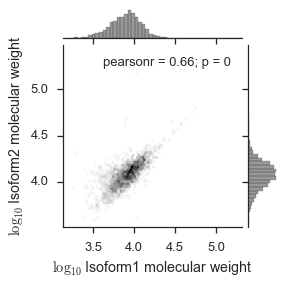

In [8]:
data = molecular_weight[molecular_weight.applymap(lambda x: isinstance(x, float))]
data = data.astype(float) 
data = np.log10(data)

g = sns.jointplot('isoform1_translation', 'isoform2_translation', data, 
                  kind='hex', joint_kws=dict(mincnt=1), color='black', size=4)
label = r'$\log_{{10}}$ Isoform{} molecular weight'
g.ax_joint.set(xlabel=label.format(1), ylabel=label.format(2))
g.ax_joint.locator_params(nbins=5)
g.savefig('{}/molecular_weight_log10.pdf'.format(figure_folder))

#### Isoelectric point (pI) 

Uses the module IsoelectricPoint to calculate the [pI](https://en.wikipedia.org/wiki/Isoelectric_point) of a protein. 

In [9]:
isoelectric_point = protein_analysis.applymap(
    lambda x: x.isoelectric_point() if isinstance(x, ProteinAnalysis) else np.nan) 
isoelectric_point.head()

,isoform1_translation,isoform2_translation
event_id,,
exon:chr10:100190328-100190427:-@exon:chr10:100189548-100189646:-@exon:chr10:100189330-100189399:-,NaN,4.268616
exon:chr10:101165513-101165617:-@exon:chr10:101163481-101163631:-@exon:chr10:101163226-101163391:-,NaN,5.374329
exon:chr10:101421203-101421385:+@exon:chr10:101439018-101439223:+@exon:chr10:101439482-101439632:+,NaN,8.703552
exon:chr10:101480744-101480825:-@exon:chr10:101478103-101478257:-@exon:chr10:101476105-101476218:-,NaN,9.807312
exon:chr10:101507014-101507147:+@exon:chr10:101510126-101510153:+@exon:chr10:101514286-101514391:+,4.329041,6.099915


In [10]:
isoelectric_point.min()

isoform1_translation    2.994324
isoform2_translation    3.219421
dtype: float64

In [11]:
isoelectric_point.max()

isoform1_translation    13.519470
isoform2_translation    12.957947
dtype: float64

isoform1_translation    2.994324
isoform2_translation    3.219421
dtype: float64
isoform1_translation    13.519470
isoform2_translation    12.957947
dtype: float64


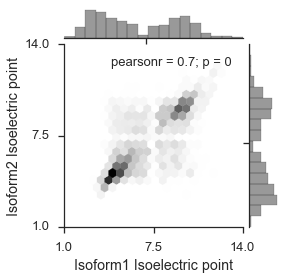

In [12]:
data = isoelectric_point
data = data[data.applymap(lambda x: isinstance(x, float))]
print data.min()
print data.max()

g = sns.jointplot('isoform1_translation', 'isoform2_translation', 
              data,
                  kind='hex', joint_kws=dict(mincnt=1), color='black', size=4)
label = r'Isoform{} Isoelectric point'
ticks = [1, 7.5, 14]
g.ax_joint.set(xlabel=label.format(1), ylabel=label.format(2),
               xticks=ticks, yticks=ticks)
g.savefig('{}/isoelectric_point.pdf'.format(figure_folder))

#### Aromaticity

Calculates the aromaticity value of a protein according to [Lobry, 1994](http://www.ncbi.nlm.nih.gov/pubmed/8065933). It is simply the relative frequency of Phe+Trp+Tyr. 

In [13]:
aromaticity = protein_analysis.applymap(
    lambda x: x.aromaticity() if isinstance(x, ProteinAnalysis) else np.nan) 
aromaticity.head()

,isoform1_translation,isoform2_translation
event_id,,
exon:chr10:100190328-100190427:-@exon:chr10:100189548-100189646:-@exon:chr10:100189330-100189399:-,NaN,0.056180
exon:chr10:101165513-101165617:-@exon:chr10:101163481-101163631:-@exon:chr10:101163226-101163391:-,NaN,0.135714
exon:chr10:101421203-101421385:+@exon:chr10:101439018-101439223:+@exon:chr10:101439482-101439632:+,NaN,0.117318
exon:chr10:101480744-101480825:-@exon:chr10:101478103-101478257:-@exon:chr10:101476105-101476218:-,NaN,0.111111
exon:chr10:101507014-101507147:+@exon:chr10:101510126-101510153:+@exon:chr10:101514286-101514391:+,0.042553,0.045455


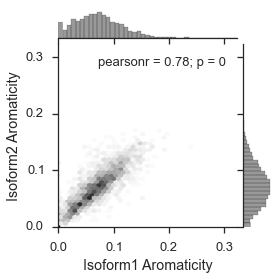

In [14]:
data = aromaticity

g = sns.jointplot('isoform1_translation', 'isoform2_translation', 
              data[data.applymap(lambda x: isinstance(x, float))], 
                  kind='hex', color='black', joint_kws=dict(mincnt=1), size=4)
label = r'Isoform{} Aromaticity'
xmin, xmax, ymin, ymax = g.ax_joint.axis()
vlim = min(xmin, ymin), max(xmax, ymax)

g.ax_joint.set(xlabel=label.format(1), ylabel=label.format(2), ylim=vlim, xlim=vlim)
g.ax_joint.locator_params(nbins=4)
g.savefig('{}/aromaticity.pdf'.format(folder))

#### Instability index

Implementation of the method of [Guruprasad et al. 1990](http://www.ncbi.nlm.nih.gov/pubmed/2075190) to test a protein for stability. Any value above 40 means the protein is unstable (has a short half life). 

In [15]:
instability_index = protein_analysis.applymap(
    lambda x: x.instability_index() if isinstance(x, ProteinAnalysis) else np.nan) 
instability_index.head()

,isoform1_translation,isoform2_translation
event_id,,
exon:chr10:100190328-100190427:-@exon:chr10:100189548-100189646:-@exon:chr10:100189330-100189399:-,NaN,102.239326
exon:chr10:101165513-101165617:-@exon:chr10:101163481-101163631:-@exon:chr10:101163226-101163391:-,NaN,33.800000
exon:chr10:101421203-101421385:+@exon:chr10:101439018-101439223:+@exon:chr10:101439482-101439632:+,NaN,34.983799
exon:chr10:101480744-101480825:-@exon:chr10:101478103-101478257:-@exon:chr10:101476105-101476218:-,NaN,50.441026
exon:chr10:101507014-101507147:+@exon:chr10:101510126-101510153:+@exon:chr10:101514286-101514391:+,52.5,50.257955


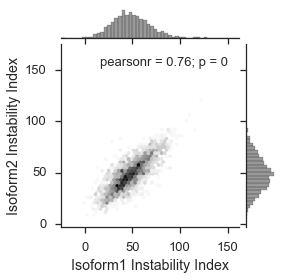

In [16]:
data = instability_index

g = sns.jointplot('isoform1_translation', 'isoform2_translation', 
              data[data.applymap(lambda x: isinstance(x, float))], 
                  kind='hex', color='black', joint_kws=dict(mincnt=1), size=4)
label = r'Isoform{} Instability Index'
g.ax_joint.set(xlabel=label.format(1), ylabel=label.format(2))
g.ax_joint.locator_params(nbins=5)
g.savefig('{}/instability_index.pdf'.format(folder))

#### Grand average of hydropathy (GRAVY)

From [GRAVY website](http://www.bioinformatics.org/sms2/protein_gravy.html): 

> Protein GRAVY returns the GRAVY (grand average of hydropathy) value for the protein sequences you enter. The GRAVY value is calculated by adding the hydropathy value for each residue and dividing by the length of the sequence ([Kyte and Doolittle; 1982](http://www.ncbi.nlm.nih.gov/pubmed/7108955?dopt=Abstract)).

In [17]:
gravy = protein_analysis.applymap(
    lambda x: x.gravy() if isinstance(x, ProteinAnalysis) else np.nan) 
gravy.head()

,isoform1_translation,isoform2_translation
event_id,,
exon:chr10:100190328-100190427:-@exon:chr10:100189548-100189646:-@exon:chr10:100189330-100189399:-,NaN,-0.664045
exon:chr10:101165513-101165617:-@exon:chr10:101163481-101163631:-@exon:chr10:101163226-101163391:-,NaN,-0.138571
exon:chr10:101421203-101421385:+@exon:chr10:101439018-101439223:+@exon:chr10:101439482-101439632:+,NaN,-0.053073
exon:chr10:101480744-101480825:-@exon:chr10:101478103-101478257:-@exon:chr10:101476105-101476218:-,NaN,0.393162
exon:chr10:101507014-101507147:+@exon:chr10:101510126-101510153:+@exon:chr10:101514286-101514391:+,0.442553,-0.017045


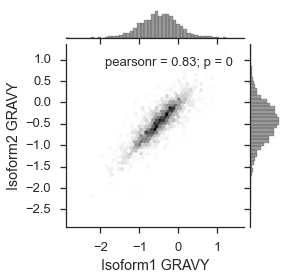

In [18]:
data = gravy

g = sns.jointplot('isoform1_translation', 'isoform2_translation', 
              data[data.applymap(lambda x: isinstance(x, float))], 
                  kind='hex', color='black', joint_kws=dict(mincnt=1), size=4)
label = r'Isoform{} GRAVY'
g.ax_joint.set(xlabel=label.format(1), ylabel=label.format(2))
# g.ax_joint.locator_params(nbins=4)
g.savefig('{}/gravy.pdf'.format(folder))

In [19]:
secondary_structure_fraction = protein_analysis.applymap(
    lambda x: pd.Series(x.secondary_structure_fraction(), index=['helix', 'turn', 'sheet']) 
    if isinstance(x, ProteinAnalysis) else pd.Series()) 
secondary_structure_fraction.head()

,isoform1_translation,isoform2_translation
event_id,,
exon:chr10:100190328-100190427:-@exon:chr10:100189548-100189646:-@exon:chr10:100189330-100189399:-,"Series([], dtype: float64)",helix 0.202247 turn 0.370787 sheet 0...
exon:chr10:101165513-101165617:-@exon:chr10:101163481-101163631:-@exon:chr10:101163226-101163391:-,"Series([], dtype: float64)",helix 0.328571 turn 0.264286 sheet 0...
exon:chr10:101421203-101421385:+@exon:chr10:101439018-101439223:+@exon:chr10:101439482-101439632:+,"Series([], dtype: float64)",helix 0.357542 turn 0.229050 sheet 0...
exon:chr10:101480744-101480825:-@exon:chr10:101478103-101478257:-@exon:chr10:101476105-101476218:-,"Series([], dtype: float64)",helix 0.384615 turn 0.196581 sheet 0...
exon:chr10:101507014-101507147:+@exon:chr10:101510126-101510153:+@exon:chr10:101514286-101514391:+,helix 0.361702 turn 0.170213 sheet 0...,helix 0.272727 turn 0.238636 sheet 0...


In [20]:
secondary_structure_tidy = pd.DataFrame(secondary_structure_fraction.unstack().to_dict()).unstack().reset_index()
secondary_structure_tidy = secondary_structure_tidy.rename(
    columns={'level_0': 'isoform', 'level_1': 'event_name', 'level_2': 'secondary_structure', 0: 'percent'})
secondary_structure_tidy.head()

,isoform,event_name,secondary_structure,percent
0,isoform1_translation,exon:chr10:100190328-100190427:-@exon:chr10:10...,helix,NaN
1,isoform1_translation,exon:chr10:100190328-100190427:-@exon:chr10:10...,sheet,NaN
2,isoform1_translation,exon:chr10:100190328-100190427:-@exon:chr10:10...,turn,NaN
3,isoform1_translation,exon:chr10:101165513-101165617:-@exon:chr10:10...,helix,NaN
4,isoform1_translation,exon:chr10:101165513-101165617:-@exon:chr10:10...,sheet,NaN


In [21]:
secondary_structure_tidy['isoform_structure'] = secondary_structure_tidy.isoform.str.split('_').str[0] \
    + '_protein_secondary_structure_' + secondary_structure_tidy.secondary_structure
secondary_structure_tidy.head()

,isoform,event_name,secondary_structure,percent,isoform_structure
0,isoform1_translation,exon:chr10:100190328-100190427:-@exon:chr10:10...,helix,NaN,isoform1_protein_secondary_structure_helix
1,isoform1_translation,exon:chr10:100190328-100190427:-@exon:chr10:10...,sheet,NaN,isoform1_protein_secondary_structure_sheet
2,isoform1_translation,exon:chr10:100190328-100190427:-@exon:chr10:10...,turn,NaN,isoform1_protein_secondary_structure_turn
3,isoform1_translation,exon:chr10:101165513-101165617:-@exon:chr10:10...,helix,NaN,isoform1_protein_secondary_structure_helix
4,isoform1_translation,exon:chr10:101165513-101165617:-@exon:chr10:10...,sheet,NaN,isoform1_protein_secondary_structure_sheet


In [22]:
secondary_structure_2d = secondary_structure_tidy.pivot(columns='isoform_structure', index='event_name', values='percent')
secondary_structure_2d.head()

isoform_structure,isoform1_protein_secondary_structure_helix,isoform1_protein_secondary_structure_sheet,isoform1_protein_secondary_structure_turn,isoform2_protein_secondary_structure_helix,isoform2_protein_secondary_structure_sheet,isoform2_protein_secondary_structure_turn
event_name,,,,,,
exon:chr10:100190328-100190427:-@exon:chr10:100189548-100189646:-@exon:chr10:100189330-100189399:-,NaN,NaN,NaN,0.202247,0.247191,0.370787
exon:chr10:101165513-101165617:-@exon:chr10:101163481-101163631:-@exon:chr10:101163226-101163391:-,NaN,NaN,NaN,0.328571,0.250000,0.264286
exon:chr10:101421203-101421385:+@exon:chr10:101439018-101439223:+@exon:chr10:101439482-101439632:+,NaN,NaN,NaN,0.357542,0.256983,0.229050
exon:chr10:101480744-101480825:-@exon:chr10:101478103-101478257:-@exon:chr10:101476105-101476218:-,NaN,NaN,NaN,0.384615,0.307692,0.196581
exon:chr10:101507014-101507147:+@exon:chr10:101510126-101510153:+@exon:chr10:101514286-101514391:+,0.361702,0.404255,0.170213,0.272727,0.306818,0.238636


## Join to splicing data

In [23]:
splicing_feature_data = pd.read_csv('{}/splicing_feature_data.csv'.format(folder), index_col=0)
print splicing_feature_data.shape
splicing_feature_data.head()

(33693, 35)


,criteria,criteria_additional,criteria_full,ensembl_id,exon1,exon1_length,exon2,exon2_length,exon3,exon3_length,...,isoform1_gc,isoform1_gc_position1,isoform1_gc_position2,isoform1_gc_position3,isoform2_gc,isoform2_gc_position1,isoform2_gc_position2,isoform2_gc_position3,isoform1_translation,isoform2_translation
event_id,,,,,,,,,,,,,,,,,,,,,
exon:chr10:100190328-100190427:-@exon:chr10:100189548-100189646:-@exon:chr10:100189330-100189399:-,best,appris_principal,"best,appris_principal",ENSG00000107521,exon:chr10:100190328-100190427:-,100,exon:chr10:100189548-100189646:-,99,exon:chr10:100189330-100189399:-,70,...,75.714286,87.500000,77.551020,60.465116,77.292576,89.610390,73.076923,68.918919,NaN,HSASSLRPADLLALILLVQDLYPSESTAEDDIQPSPRRARSSQNIP...
exon:chr10:100193697-100193848:-@exon:chr10:100190888-100191048:-@exon:chr10:100190328-100190427:-,only one,NaN,only one,ENSG00000107521,exon:chr10:100193697-100193848:-,152,exon:chr10:100190888-100191048:-,161,exon:chr10:100190328-100190427:-,100,...,79.523810,88.311688,74.242424,74.626866,79.178886,73.333333,89.256198,73.913043,NaN,NaN
exon:chr10:100195392-100195529:-@exon:chr10:100195029-100195171:-@exon:chr10:100193697-100193848:-,best,appris_principal,"best,appris_principal",ENSG00000107521,exon:chr10:100195392-100195529:-,138,exon:chr10:100195029-100195171:-,143,exon:chr10:100193697-100193848:-,152,...,78.111588,81.927711,73.239437,78.481013,75.882353,75.206612,53.684211,93.548387,NaN,NaN
exon:chr10:101165513-101165617:-@exon:chr10:101163481-101163631:-@exon:chr10:101163226-101163391:-,only one,NaN,only one,ENSG00000120053,exon:chr10:101165513-101165617:-,105,exon:chr10:101163481-101163631:-,151,exon:chr10:101163226-101163391:-,166,...,68.899522,62.318841,70.588235,73.611111,71.246006,70.642202,58.585859,83.809524,NaN,NAPEFSIVVLHACAHNPTGIDPTPEQWKQIASVMKHRFLFPFFDSA...
exon:chr10:101419263-101419345:+@exon:chr10:101419619-101419721:+@exon:chr10:101421203-101421385:+,only one,NaN,only one,ENSG00000198018,exon:chr10:101419263-101419345:+,83,exon:chr10:101419619-101419721:+,103,exon:chr10:101421203-101421385:+,183,...,74.111675,74.242424,76.271186,72.222222,70.833333,66.666667,71.276596,75.000000,NaN,NaN


### Join on all created dataframes

In [24]:
join_dfs = {'gravy': gravy, 'instability_index': instability_index,
            'aromaticity': aromaticity, 'isoelectric_point': isoelectric_point,
            'molecular_weight': molecular_weight, 'secondary_structure': secondary_structure_2d}

for name, df in join_dfs.items():
    # If "translation" is in the column name, then it hasn't been renamed to its property
    if df.columns.map(lambda x: 'translation' in x).sum() > 0:
        df.columns = df.columns.map(lambda x: x.replace('translation', name))
    join_cols = df.columns.difference(splicing_feature_data.columns)
    if len(join_cols) > 0:
        splicing_feature_data = splicing_feature_data.join(df[join_cols])
    else:
        splicing_feature_data[df.columns] = df
splicing_feature_data.head()

,criteria,criteria_additional,criteria_full,ensembl_id,exon1,exon1_length,exon2,exon2_length,exon3,exon3_length,...,isoform1_molecular_weight,isoform2_molecular_weight,isoform1_protein_secondary_structure_helix,isoform1_protein_secondary_structure_sheet,isoform1_protein_secondary_structure_turn,isoform2_protein_secondary_structure_helix,isoform2_protein_secondary_structure_sheet,isoform2_protein_secondary_structure_turn,isoform1_aromaticity,isoform2_aromaticity
event_id,,,,,,,,,,,,,,,,,,,,,
exon:chr10:100190328-100190427:-@exon:chr10:100189548-100189646:-@exon:chr10:100189330-100189399:-,best,appris_principal,"best,appris_principal",ENSG00000107521,exon:chr10:100190328-100190427:-,100,exon:chr10:100189548-100189646:-,99,exon:chr10:100189330-100189399:-,70,...,NaN,9467.0555,NaN,NaN,NaN,0.202247,0.247191,0.370787,NaN,0.056180
exon:chr10:100193697-100193848:-@exon:chr10:100190888-100191048:-@exon:chr10:100190328-100190427:-,only one,NaN,only one,ENSG00000107521,exon:chr10:100193697-100193848:-,152,exon:chr10:100190888-100191048:-,161,exon:chr10:100190328-100190427:-,100,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
exon:chr10:100195392-100195529:-@exon:chr10:100195029-100195171:-@exon:chr10:100193697-100193848:-,best,appris_principal,"best,appris_principal",ENSG00000107521,exon:chr10:100195392-100195529:-,138,exon:chr10:100195029-100195171:-,143,exon:chr10:100193697-100193848:-,152,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
exon:chr10:101165513-101165617:-@exon:chr10:101163481-101163631:-@exon:chr10:101163226-101163391:-,only one,NaN,only one,ENSG00000120053,exon:chr10:101165513-101165617:-,105,exon:chr10:101163481-101163631:-,151,exon:chr10:101163226-101163391:-,166,...,NaN,15790.6691,NaN,NaN,NaN,0.328571,0.250000,0.264286,NaN,0.135714
exon:chr10:101419263-101419345:+@exon:chr10:101419619-101419721:+@exon:chr10:101421203-101421385:+,only one,NaN,only one,ENSG00000198018,exon:chr10:101419263-101419345:+,83,exon:chr10:101419619-101419721:+,103,exon:chr10:101421203-101421385:+,183,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
splicing_feature_data.shape

(33693, 51)

In [27]:
pd.options.display.max_columns = 50

In [28]:
isoform_cols = [x for x in splicing_feature_data.columns if 'isoform' in x]
print len(isoform_cols)
splicing_feature_data[isoform_cols].head()

26


,isoform1_gc,isoform1_gc_position1,isoform1_gc_position2,isoform1_gc_position3,isoform2_gc,isoform2_gc_position1,isoform2_gc_position2,isoform2_gc_position3,isoform1_translation,isoform2_translation,isoform1_gravy,isoform2_gravy,isoform1_isoelectric_point,isoform2_isoelectric_point,isoform1_instability_index,isoform2_instability_index,isoform1_molecular_weight,isoform2_molecular_weight,isoform1_protein_secondary_structure_helix,isoform1_protein_secondary_structure_sheet,isoform1_protein_secondary_structure_turn,isoform2_protein_secondary_structure_helix,isoform2_protein_secondary_structure_sheet,isoform2_protein_secondary_structure_turn,isoform1_aromaticity,isoform2_aromaticity
event_id,,,,,,,,,,,,,,,,,,,,,,,,,,
exon:chr10:100190328-100190427:-@exon:chr10:100189548-100189646:-@exon:chr10:100189330-100189399:-,75.714286,87.500000,77.551020,60.465116,77.292576,89.610390,73.076923,68.918919,NaN,HSASSLRPADLLALILLVQDLYPSESTAEDDIQPSPRRARSSQNIP...,NaN,-0.664045,NaN,4.268616,NaN,102.239326,NaN,9467.0555,NaN,NaN,NaN,0.202247,0.247191,0.370787,NaN,0.056180
exon:chr10:100193697-100193848:-@exon:chr10:100190888-100191048:-@exon:chr10:100190328-100190427:-,79.523810,88.311688,74.242424,74.626866,79.178886,73.333333,89.256198,73.913043,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
exon:chr10:100195392-100195529:-@exon:chr10:100195029-100195171:-@exon:chr10:100193697-100193848:-,78.111588,81.927711,73.239437,78.481013,75.882353,75.206612,53.684211,93.548387,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
exon:chr10:101165513-101165617:-@exon:chr10:101163481-101163631:-@exon:chr10:101163226-101163391:-,68.899522,62.318841,70.588235,73.611111,71.246006,70.642202,58.585859,83.809524,NaN,NAPEFSIVVLHACAHNPTGIDPTPEQWKQIASVMKHRFLFPFFDSA...,NaN,-0.138571,NaN,5.374329,NaN,33.800000,NaN,15790.6691,NaN,NaN,NaN,0.328571,0.250000,0.264286,NaN,0.135714
exon:chr10:101419263-101419345:+@exon:chr10:101419619-101419721:+@exon:chr10:101421203-101421385:+,74.111675,74.242424,76.271186,72.222222,70.833333,66.666667,71.276596,75.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Save the data!

In [29]:
splicing_feature_data.to_csv('/projects/ps-yeolab/obotvinnik/singlecell_pnms/splicing_feature_data.csv')

In [30]:
splicing_feature_data.shape

(33693, 51)